# Normal distribution 

The simplest model: the Normal distribution. It is used as a basic components in many more complex models.

In [1]:
using Pkg
Pkg.activate("../");

using LinearAlgebra
using Plots
using Random

import ExpFamilyDistributions
const EFD = ExpFamilyDistributions

using Revise
using BayesianModels

# Plotting function
include("plotting.jl");

  Activating environment at `~/Repositories/BayesianModels.jl/Project.toml`
┌ Info: Precompiling BayesianModels [1400088c-90aa-43b9-ae43-7211fec07595]
└ @ Base loading.jl:1317


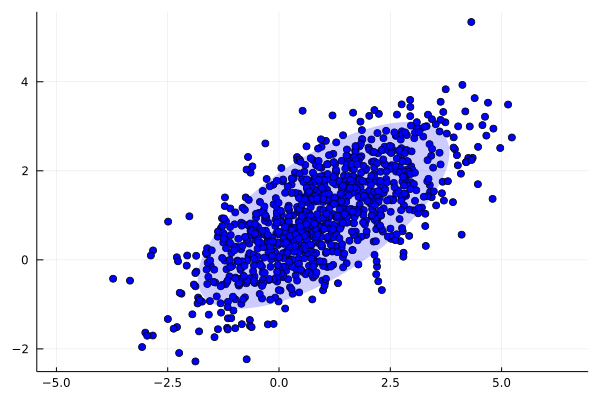

In [2]:
T = Float64
μₓ = T[1, 1] 
Σₓ = T[2 1; 1.0  1.1]
#Σₓ = T[2 0; 0  1.1]

function draw(n, μ, Σ)
    L = cholesky(Σ).L
    hcat([μ + L*randn(T, 2) for i in 1:n]...)
end

X = draw(1000, μₓ, Σₓ)
p = plot(legend = false, aspect_ratio = 1)
scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(μₓ, Σₓ, σ = 2, color = :blue, linewidth = 0, fillalpha = 0.2)

In [9]:
D = 2
model_full = BayesianModels.Normal(D, pstrength = 1)
model_diag = BayesianModels.NormalDiag(D, pstrength = 1)

BayesianModels.NormalDiagIndependentParams{2} (
  (μ): BayesianModels.BayesianParameter{ExpFamilyDistributions.NormalDiag{2}, ExpFamilyDistributions.NormalDiag{2}, AutoGrad.Param{Vector{Float64}}}
  (λ): BayesianModels.BayesianParameter{ExpFamilyDistributions.Gamma{2}, ExpFamilyDistributions.Gamma{2}, AutoGrad.Param{Vector{Float64}}}
)


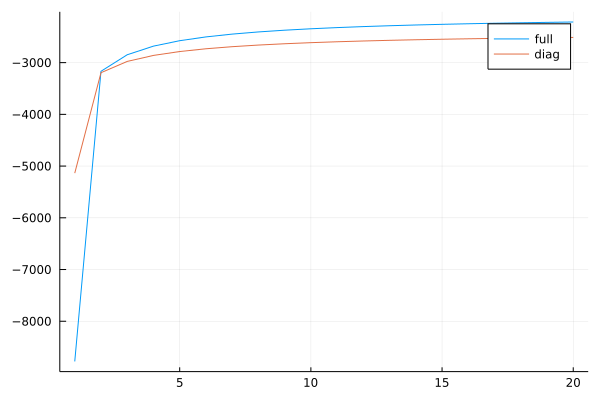

In [10]:
function fit(model, X; lrate = 0.001, steps = 1)
    elbos = []
    params = filter(isbayesianparam, getparams(model))
    for step in 1:steps
        𝓛, ∇ξ = ∇elbo(model, X; params)
        gradstep(∇ξ, lrate = lrate)
        push!(elbos, 𝓛)
    end
    elbos
end
steps = 20
elbos_full = fit(model_full, X, steps = steps)
elbos_diag = fit(model_diag, X, steps = steps)
plot(elbos_full, label = "full")
plot!(elbos_diag, label = "diag")

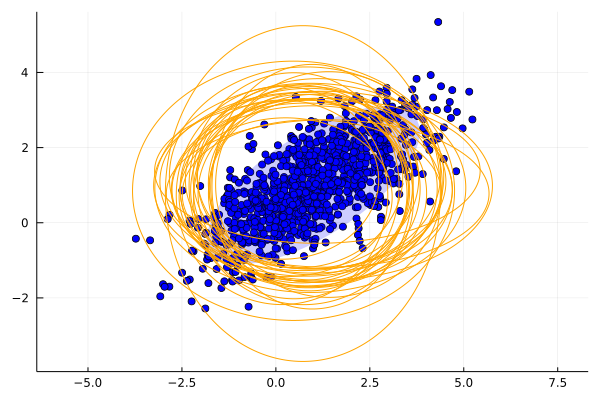

In [17]:
p = plot(legend = false, aspect_ratio = 1)
scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(μₓ, Σₓ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)

μs = EFD.sample(model_diag.μ.posterior, 30)
#Σs = [inv(Λₗ) for Λₗ in EFD.sample(model.Λ.posterior, 30)]
λ = EFD.sample(model_diag.λ.posterior, 30)
Σs = [diagm(1 ./ λᵢ) for λᵢ in eachcol(λ)]
for (μ, Σ) in zip(eachcol(μs), Σs)
    plotnormal!(μ, Σ, σ = 2, color = :orange, linecolor = :orange, fillalpha = 0)
end

p

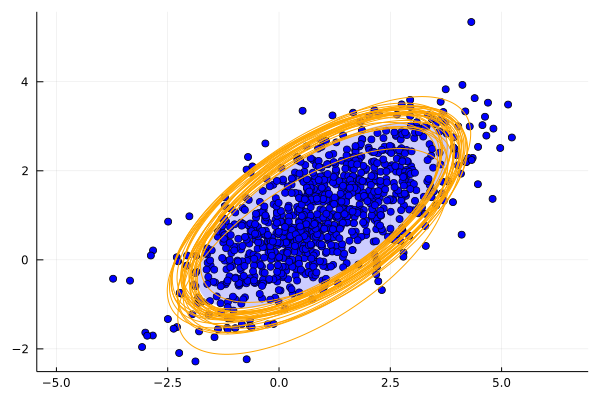

In [19]:
p = plot(legend = false, aspect_ratio = 1)
scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(μₓ, Σₓ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)

μs = EFD.sample(model_full.μ.posterior, 30)
Λs = EFD.sample(model_full.Λ.posterior, 30)
Σs = [inv(Λs[:, :, i]) for i in size(Λs, 3)]
Σs = [Σ for i in 1:30]
#Σs = [diagm(1 ./ λₗ) for λₗ in eachrow(hcat(EFD.sample.(getproperty.(model.λ, :posterior), 30)...))]
for (μ, Σ) in zip(eachcol(μs), Σs)
    plotnormal!(μ, Σ, σ = 2, color = :orange, linecolor = :orange, fillalpha = 0)
end

p

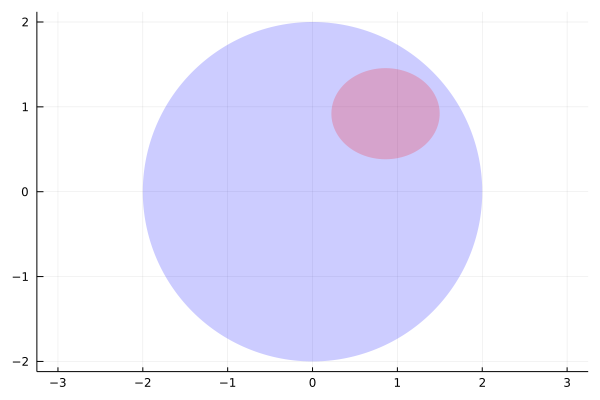

In [20]:
p = plot(legend = false, aspect_ratio = 1)
#scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(model_diag.μ.prior.μ, model_diag.μ.prior.Σ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)
plotnormal!(model_diag.μ.posterior.μ, model_diag.μ.posterior.Σ, σ = 2, color = :red, linecolor = :red, linewidth = 0, fillalpha = 0.2)

p

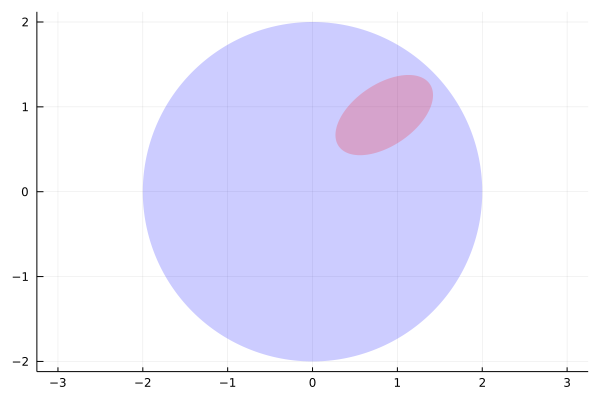

In [21]:
p = plot(legend = false, aspect_ratio = 1)
#scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(model_full.μ.prior.μ, model_full.μ.prior.Σ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)
plotnormal!(model_full.μ.posterior.μ, model_full.μ.posterior.Σ, σ = 2, color = :red, linecolor = :red, linewidth = 0, fillalpha = 0.2)

p